# Métricas en clasificación

En este Notebook vamos analizar distintas métricas y algoritmos sobre un problema de clasificación desbalanceado. 

## Contenidos

1. Análisis exploratorio
2. Métricas clasificación
3. Comparación clasificadores

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [3]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

# 1. Análisis exploratorio

Vamos a trabajar con datos de fuga de una compañía telefónica. El objetivo es predecir cuándo los clientes van a abandonar la compañía.

<div class = "alert alert-success">
**EJERCICIO**: Cargue los datos *churn.csv* y realice un primer análisis de los datos cargados
</div>

<div class = "alert alert-success">
**EJERCICIO**: Este problema está desbalanceado, calcule el ratio de desbalanceo
</div>

In [4]:
data = pd.read_csv('./data/churn.csv')
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
account length,128,107,137,84,75
area code,415,415,415,408,415
phone number,382-4657,371-7191,358-1921,375-9999,330-6626
international plan,no,no,no,yes,yes
voice mail plan,yes,yes,no,no,no
number vmail messages,25,26,0,0,0
total day minutes,265.1,161.6,243.4,299.4,166.7
total day calls,110,123,114,71,113
total day charge,45.07,27.47,41.38,50.9,28.34


In [5]:
data.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
account length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
area code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
number vmail messages,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
total day minutes,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
total day calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
total day charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
total eve minutes,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
total eve calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
total eve charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91
total night minutes,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00


In [7]:
(data['churn'].value_counts() / data.shape[0])*100

False    85.508551
True     14.491449
Name: churn, dtype: float64

##  1.1 preprocesamiento de variables

Si escribimos *data.dtypes* nos indica el tipo de las variables de nuestro dataframe. Vemos que tenemos variables categóricas que tenemos que codificar. 

<div class = "alert alert-success">
**EJERCICIO**: Elimine la variable *phone number* y codifique las variables categóricas.
</div>

In [8]:
data.drop(['phone number'], axis=1, inplace=True)

In [9]:
data.dtypes

state                      object
account length              int64
area code                   int64
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [10]:
from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()

data['state'] = le1.fit_transform(data['state'])
data['international plan'] = le2.fit_transform(data['international plan'])
data['voice mail plan'] = le3.fit_transform(data['voice mail plan'])
data['churn'] = le4.fit_transform(data['churn'])



In [11]:
data.dtypes

state                       int64
account length              int64
area code                   int64
international plan          int64
voice mail plan             int64
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                       int64
dtype: object

In [12]:
le1.classes_

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [13]:
le2.classes_

array(['no', 'yes'], dtype=object)

In [14]:
le3.classes_

array(['no', 'yes'], dtype=object)

In [15]:
le4.classes_

array([False,  True])

In [16]:
# Si tuviera un dataset de test, lo que haría es:

#data_test['state'] = le1.transform(data_test['state'])
#data_test['international plan'] = le2.transform(data_test['international plan'])
#data_test['voice mail plan'] = le3.transform(data_test['voice mail plan'])
#data_test['churn'] = le4.transform(data_test['churn'])

<div class = "alert alert-success">
**EJERCICIO**: Represente el histograma de las variable con distintos colores para cada clase.
</div>

In [ ]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 =  data['churn'] == 0
idx_1 =  data['churn'] == 1

for i,feature in enumerate(data.columns.drop(['churn'])):
    plt.subplot(5, 5,i+1)   
    plt.hist(data.loc[idx_0,feature],density=0, alpha=0.75,label='y=0')
    plt.hist(data.loc[idx_1,feature],density=0, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

## 1.2 Correlación entre variables

<div class = "alert alert-success">
**EJERCICIO**: Represente el mapa de correlación entre variables
</div>

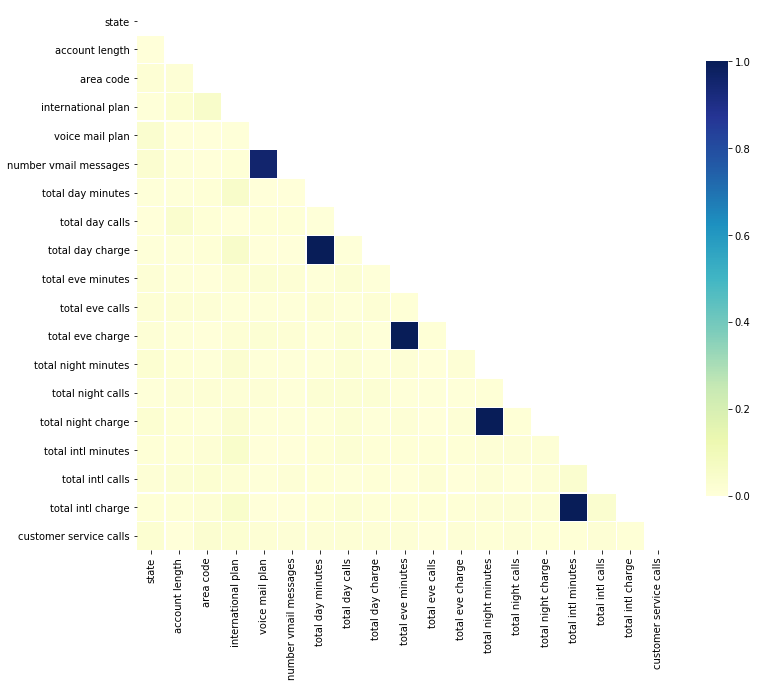

In [31]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['churn'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

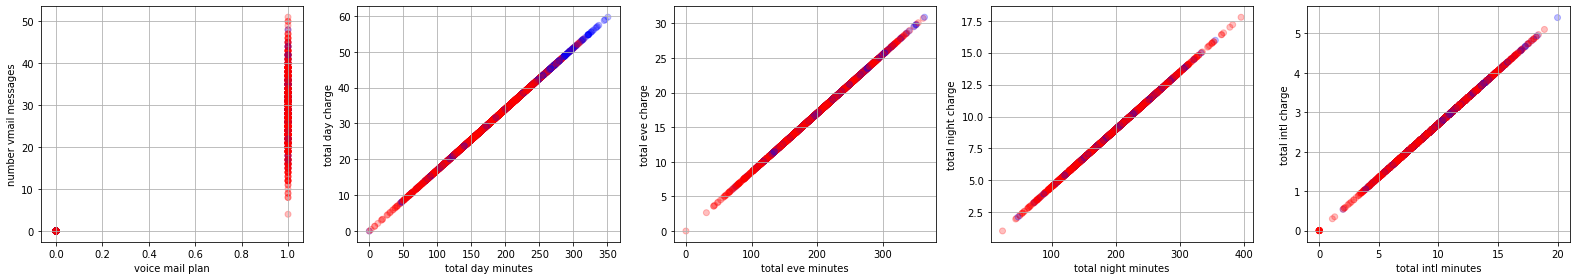

In [32]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
pairs = np.where(upper>0.95)
fx = data.columns[pairs[0]]
fy =  data.columns[pairs[1]]

i=1
plt.figure(figsize=(22,4))
for f1,f2 in zip(fx,fy):
    
    plt.subplot(1,5,i)
    
    plt.scatter(data[f1],data[f2], c=data['churn'],cmap=cm_bright, alpha=0.25)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.grid()
    plt.tight_layout()
    
    i+=1
    
plt.show()

En clasificación, variables correlacionadas no afectan al proceso de clasificación. Sin embargo, dada la correlación extrema y con el objetivo de eliminar variables poco informativas, podemos eliminar algunas columnas.

In [33]:
columns_to_drop = ['total day minutes','total eve minutes','total night minutes','total intl minutes']
data.drop(columns_to_drop, axis=1, inplace=True)
data.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,0,1,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0
1,35,107,415,0,1,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0
2,31,137,415,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0
3,35,84,408,1,0,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0
4,36,75,415,1,0,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0


# 2. Métricas en clasificación

Vamos a representar la matriz de confusión, y a partir de ella calcular distintas métricas. Para ello, comencemos un clasificador sencillo: regresión logística.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# preparamos los datos

features = data.columns.drop('churn')

X = data[features].values
y = data['churn'].values


# PASO 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=0)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Proporcion train:%0.3f'%np.mean(y_train))
print('Propocrion test: %0.3f'%np.mean(y_test))


Datos train:  (2499, 15)
Datos test:   (834, 15)
Propocion train:0.145
Propocion test: 0.145


## 2.1 Matriz de confusión y métricas

<div class = "alert alert-success">
**EJERCICIO**: Ajuste un algoritmo de regresión logística sobre el conjunto de entrenamiento con $C = 1$. Calcule la predicción para el conjunto de entrenamiento (*y_pred*).
</div>

In [36]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1).fit(Xs_train, y_train)

y_pred_train = lr.predict(Xs_train)

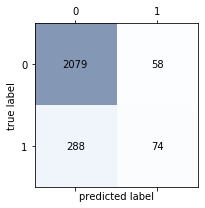

In [38]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_train,y_pred_train)
plot_confusion_matrix(confmat)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()

<div class = "alert alert-success">
**EJERCICIO**: A partir de las TP, TN, FP, FN, calcula las siguiente métricas: SEN, ESP, PPV, FSC, ACC.
</div>

ACC:  0.8615446178471389
SEN:  0.20441988950276244
ESP:  0.9728591483387927
PPV:  0.5606060606060606
FSC:  0.29959514170040485


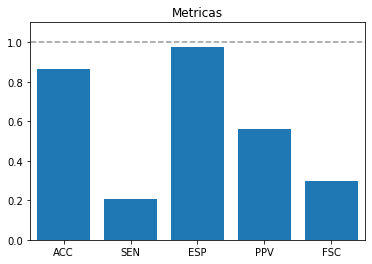

In [39]:
calcula_metricas(confmat)

<div class = "alert alert-success">
**EJERCICIO**: Calcula las métricas de performance en el conjunto de test.
</div>

ACC:  0.86810551558753
SEN:  0.23140495867768596
ESP:  0.9761570827489481
PPV:  0.6222222222222222
FSC:  0.3373493975903615


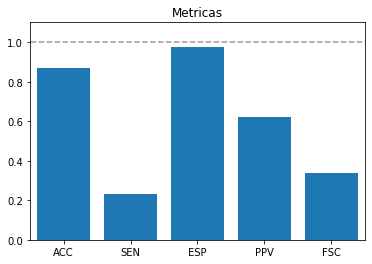

In [40]:
y_pred_test = lr.predict(Xs_test)
confmat = confusion_matrix(y_test,y_pred_test)
calcula_metricas(confmat)

<div class = "alert alert-success">
**EJERCICIO**: Representa el histograma de probabilidad estimada *y_prob* para el conjunto de test. Representa de distinto color cada una de las clases. 
</div>

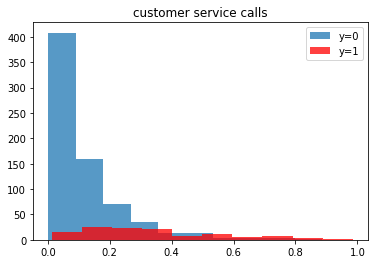

In [41]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

plt.hist(y_prob[idx_0], density=0, alpha=0.75,label='y=0')
plt.hist(y_prob[idx_1], density=0, facecolor='red', alpha=0.75,label='y=1')
plt.legend()
plt.title(feature)
plt.show()

Por último, vamos a representar la curva ROC.

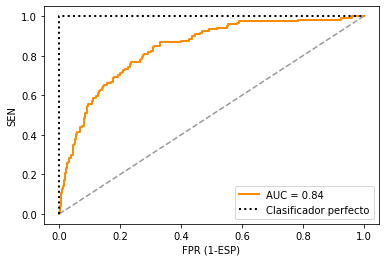

In [42]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

In [43]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1, class_weight='balanced').fit(Xs_train, y_train)

y_pred_train = lr.predict(Xs_train)

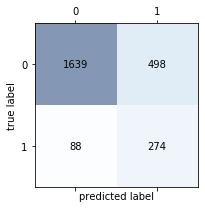

In [44]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_train,y_pred_train)
plot_confusion_matrix(confmat)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()

# 3. Comparación clasificadores

Vamos a comparar los siguientes clasificadores: 

* Regresión logística
* Árboles de decisión
* Random Forest

<div class = "alert alert-success">
**EJERCICIO**: Calcule los parámetros libres óptimos para cada clasificador. Ajuste un modelo con dichos parámetros y compare las métricas obtenidas con cada uno de ellos
</div>

## 3.1 Regresión logística

Hemos visto que este algoritmo está sesgado hacia la clase mayoritoria. Para compensar esta situación, podemos asignar pesos distintos a los errores cometidos en cada una de las clases, a través del parámetro [*class_weight*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Además, podemos trabajar con distintas [métricas](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) a la hora de optimizar los parámetros libres. Para conjuntos desbalancedados es adecuada:

* 'f1': F1-score, compromiso entre SEN, y PPV.


best mean cross-validation score: 0.486
best parameters: {'C': 0.007943282347242814}
Log(C): -2.1


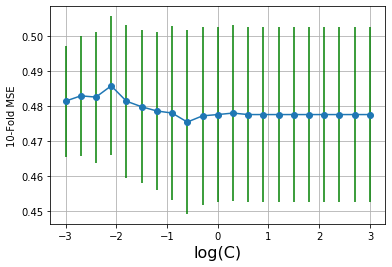

In [49]:
from sklearn.model_selection import GridSearchCV
import math

vectorC = np.logspace(-3,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 5)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print(f"Log(C): {math.log10(grid.best_params_['C'])}")

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

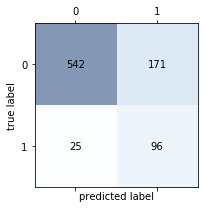

ACC:  0.7649880095923262
SEN:  0.7933884297520661
ESP:  0.7601683029453016
PPV:  0.3595505617977528
FSC:  0.4948453608247423


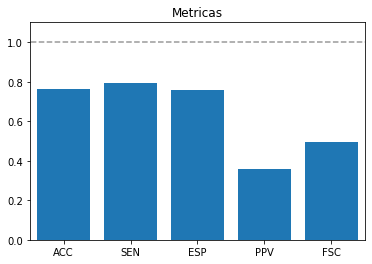

In [50]:
Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt, class_weight='balanced').fit(Xs_train,y_train)
y_pred = lr.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

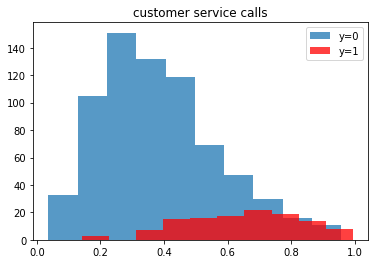

In [51]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

plt.hist(y_prob[idx_0], density=0, alpha=0.75,label='y=0')
plt.hist(y_prob[idx_1], density=0, facecolor='red', alpha=0.75,label='y=1')
plt.legend()
plt.title(feature)
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Compare el resultado con respecto a entrenar maximizando *accuracy* y sin balancear las clases.
</div>

best mean cross-validation score: 0.862
best parameters: {'C': 0.007943282347242814}
Log(C): -2.1


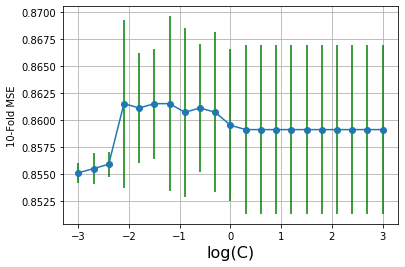

In [53]:
from sklearn.model_selection import GridSearchCV
import math

vectorC = np.logspace(-3,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0),
                    scoring='accuracy', 
                    param_grid=param_grid, 
                    cv = 5)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print(f"Log(C): {math.log10(grid.best_params_['C'])}")

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

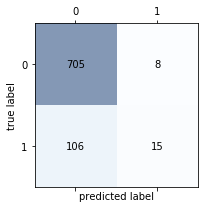

ACC:  0.8633093525179856
SEN:  0.12396694214876033
ESP:  0.9887798036465638
PPV:  0.6521739130434783
FSC:  0.20833333333333334


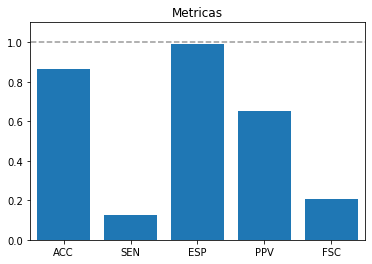

In [55]:
Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt).fit(Xs_train,y_train)
y_pred = lr.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

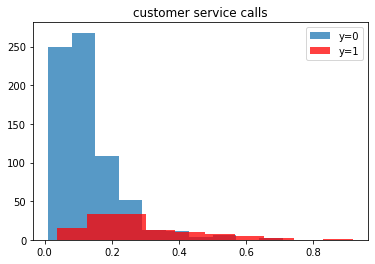

In [56]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

plt.hist(y_prob[idx_0], density=0, alpha=0.75,label='y=0')
plt.hist(y_prob[idx_1], density=0, facecolor='red', alpha=0.75,label='y=1')
plt.legend()
plt.title(feature)
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Una vez fijados los parámetros libres, represente la curva ROC. 
</div>

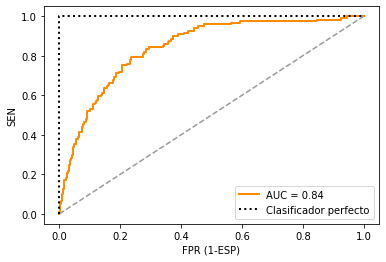

In [52]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

## 3.2 Árboles de decisión

Entrenamos ahora un árbol de decisión. Otra ventaja adicional de los árboles es que por su construcción hace frente al desbalanceo de las clases.

<div class = "alert alert-success">
**EJERCICIO**: Entrena un árbol de decisión y calcula las métricas obtenidas en el conjunto de test.
</div>

In [ ]:
from sklearn.tree import DecisionTreeClassifier

maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }



<div class = "alert alert-success">
**EJERCICIO**: Visualiza el árbol de decisión entrenado para comprender las predicciones realizadas.
</div>

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=features,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph

## 3.3 Random Forest

Comprobemos prestaciones para un algoritmo de Random Forest.

<div class = "alert alert-success">
**EJERCICIO**: Entrena un algoritmo de Random Forest y calcula las métricas obtenidas en el conjunto de test.
</div>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# grid search
maxDepth   = range(1,15)
param_grid = {'max_depth': maxDepth}



<div class = "alert alert-success">
**EJERCICIO**@home: Entrena una SVM y Boosted Trees
</div>